In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from chart_studio.plotly import image as PlotlyImage
from PIL import Image as PILImage
import io
import chart_studio
from IPython.display import Image
import random

rawdata = pd.read_csv('https://data.cdc.gov/api/views/u6jv-9ijr/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=')

rawdata = rawdata[rawdata['Jurisdiction'] != 'United States']

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [2]:
def get_pivottable():
    gte2020 = rawdata[rawdata['Year'] == 2020].groupby(['Jurisdiction', 'Week'])[['Number of Deaths']].sum()
    maxweek = gte2020.reset_index()['Week'].max()
    lt2020 = rawdata[(rawdata['Year'] < 2020) & (rawdata['Week'] <= maxweek)].groupby(['Jurisdiction', 'Year', 'Week']).sum()[['Number of Deaths']].groupby(['Jurisdiction', 'Week']).mean()#.rename(columns={'Number of Deaths': 'Avg'})

    compareData = lt2020.copy().rename(columns={'Number of Deaths':'Average'})

    compareData['2020'] = gte2020['Number of Deaths']

    compareData = compareData.fillna(0)

    compareData['Difference'] = (compareData['2020'].div(compareData['Average']) * 100) - 100

    compareData = compareData.reset_index()

    pivottable = compareData.pivot(index='Week', columns='Jurisdiction', values='Difference')

    pivottable['Week Ending'] = pd.to_datetime(rawdata[rawdata['Year'] == 2020].groupby(['Week'])['Week Ending Date'].max())
    pivottable = pivottable.reset_index().set_index('Week Ending').drop(['Week'], axis=1)
    return pivottable

def get_normalized_excess_deaths():
    pivottable = get_pivottable()
    states = pivottable.columns

    fig, ax = plt.subplots(figsize=(15,20))  

    pvt2 = pivottable.copy()
    pvt2['New York'] = pvt2['New York'] + pvt2['New York City']
    pvt2 = pvt2.drop(['New York City'], axis=1)

    df_norm_col=(pvt2-pvt2.mean())/pvt2.std()
    df_norm_col_2 = df_norm_col.reindex(df_norm_col.idxmax().sort_values().index, axis=1)

    df_norm_col_2 = df_norm_col_2.rolling(window=3).mean().dropna()

    sns.heatmap(df_norm_col_2.transpose(), xticklabels=True, yticklabels=True, ax=ax, cbar=False, linewidths=2, linecolor='white', cmap="Reds")
    x_dates = df_norm_col_2.index.strftime('%Y-%m-%d').sort_values().unique()

    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('Normalized Excess Deaths, 2020 vs 2015-2019', size=30, pad=20)

    plt.annotate('Reported deaths per week in 2020 vs the same time period\'s average in 2015-2019, and sorted by peak. Source: CDC', (0,0), (100, -70), xycoords='axes fraction', textcoords='offset points', va='top')

def get_gif_map():
    pivottable = get_pivottable()
    pivottable2 = pivottable.copy()

    pivottable2 = pivottable2.rename(columns=us_state_abbrev)


    sortedvalues = np.sort(pivottable2.values.flatten().flatten())
    mx = max(sortedvalues)
    rg = max(sortedvalues) - min(sortedvalues)
    mn = min(sortedvalues)
    pivottable3 = (pivottable2 - mn).div(rg)
    pivottable3 = pivottable3.resample(rule='8H').asfreq().interpolate()

    bins = pd.qcut(sortedvalues, q=8, retbins=True)[1]
    bins = (bins - bins.min()) / (bins.max() - bins.min())

    colorscale = list(zip(bins, getattr(px.colors.sequential, 'Reds')))

    images = []

    for i in np.arange(0, pivottable3.shape[0]):

        data = pivottable3.iloc[i]
        fig = go.Figure(
            data=go.Choropleth(
                locations=data.index,
                z = data,
                locationmode = 'USA-states',
                colorscale = colorscale,
                showscale=False,
                zmin=0,
                zmax=1
            )
        )


        fig.update_layout(
            title= {
                "text":'Daily Excess Deaths ' + data.name.strftime('%-m-%-d-%Y'),
                'xanchor': 'center',
                'x':0.5
            },
            font=dict(
                size=18
            ),
            geo_scope='usa', # limite map scope to USA
            annotations=[
               go.layout.Annotation(
                    showarrow=False,
                    text='Source: CDC Excess Deaths (https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm)',
                    xanchor='center',
                    x=.5,
                    yanchor='bottom',
                    y=-0.2,
                    font=dict(
                        size=12
                    )
            ),
            go.layout.Annotation(
                    showarrow=False,
                    text='Darker colors indicate a higher death rate for 2020 when compared to the same time period in 2015-2019',
                    xanchor='center',
                    x=0.5,
                    yanchor='bottom',
                    y=-0.15,
                    font=dict(
                        size=12
                    ))]
        )


        img_bytes = fig.to_image(format='png')
        image = PILImage.open(io.BytesIO(img_bytes))
        #image.save("gifdata/"+str(data.name).replace(':', '-')+".png")

        images.append(image)
        if i == pivottable3.shape[0] - 1:
            for i in np.arange(0,40):
                images.append(image)

    url = 'covid19-case.gif'
    images[0].save(url,
                   save_all=True, append_images=images[1:], optimize=True, duration=75, loop=0)
    return url + "?c=" + str(random.randint(0,2e9))


In [3]:
url = get_gif_map()
Image(url=url)

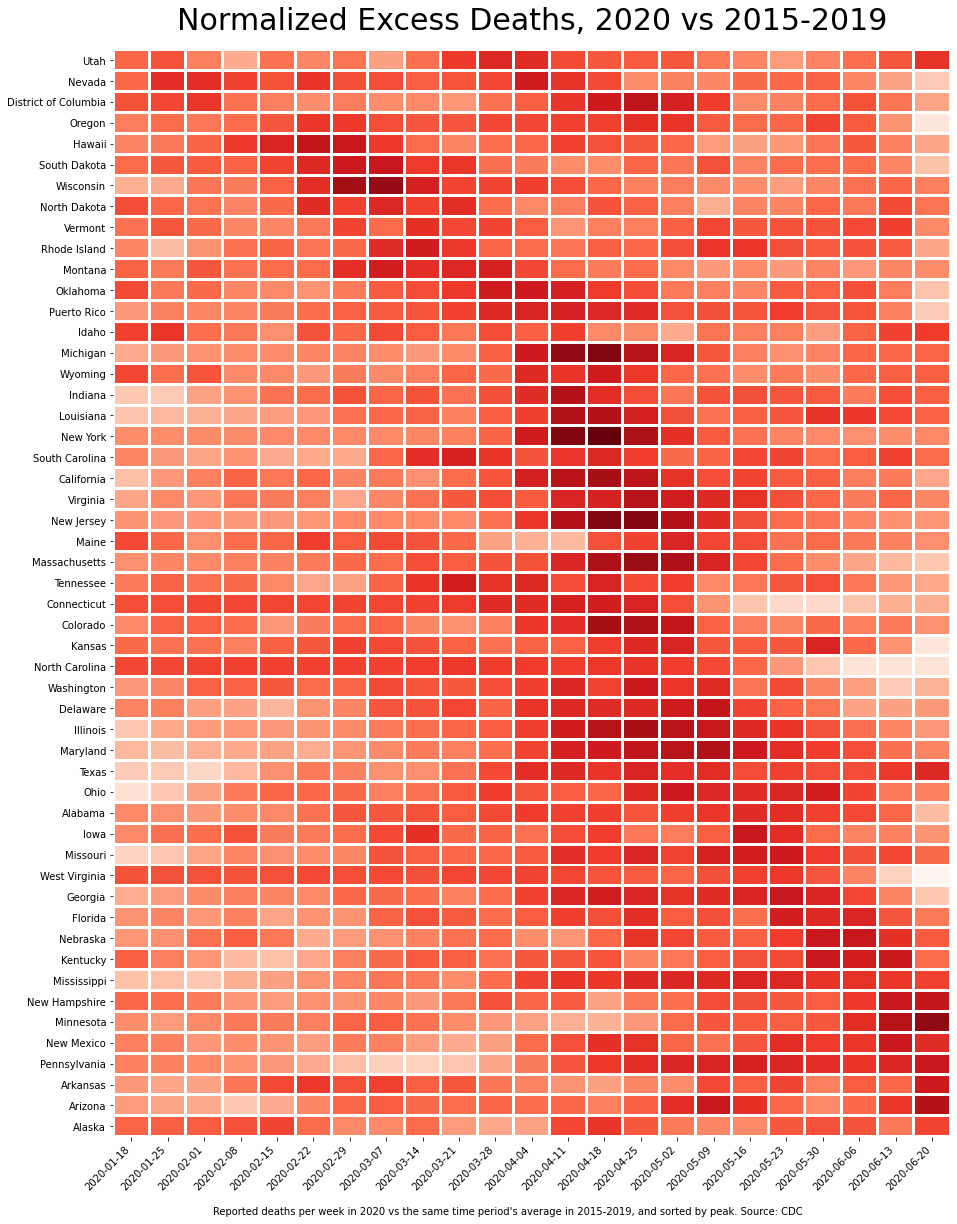

In [4]:
get_normalized_excess_deaths()